In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
# sys.path.append('/Users/user/projects/SpyDust/')

from SpyDust.Grain import *

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])


## Grain size and shape distribution

In [2]:
grain_obj = grain_distribution()
f_a_beta = grain_obj.shape_and_size_dist(6, a_weighted=True, normalize=True)
a_tab = grain_obj.a_tab
beta_tab = grain_obj.beta_tab

## An example of the angular momentum distribution: 
### $f(\Omega|a, \beta, \mu)$  (given grain properties)

In [3]:
DC_params = {'nh' : 1e4, 'T': 10., 'Chi': 1e-4, 'xh': 0., 'xC': 1e-6, 'y' : 0.999,  'gamma': 0, 'dipole': 9.3, 'line':7}

MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3, 'line':7}    

CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WNM_params = {'nh' : 0.4, 'T': 6000., 'Chi': 1., 'xh': 0.1, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WIM_params = {'nh' : 0.1, 'T': 8000., 'Chi': 1., 'xh': 0.99, 'xC': 1e-3, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

RN_params = {'nh' : 1000., 'T': 100., 'Chi': 1000., 'xh': 0.001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

PDR_params = {'nh' : 1e5, 'T': 300., 'Chi': 3000., 'xh': 0.0001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

Use an example grain size and shape

In [4]:
from SpyDust.util import cgsconst
from SpyDust.AngMomDist import log_f_rot
from SpyDust.charge_dist import charge_dist

debye = cgsconst.debye
env = CNM_params
dip_per_at = env['dipole'] / np.sqrt(N_C(1e-7) + N_H(1e-7)) * debye

aind = 5
a = a_tab[aind]
beta = beta_tab[np.argmax(f_a_beta[aind, :])]
fZ = charge_dist(env, a, beta)
Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
print(a, beta)

5.3382803478865665e-08 -0.3425


### Run on the parameter grid

In [5]:
nh_list = [1e-1, 1e1, 1e3, 1e5]
T_list = [1e1, 1e2, 1e3, 1e4]
chi_list = [1e-4, 1e-1, 10, 1e3]
xh_list = [0, 1e-1, 0.5, 0.99]
xC_list = [1e-6, 1e-5, 1e-4, 1e-3]
y_list = [0, 0.3, 0.6, 0.999]
dipole_list = [5, 9.3, 15]

a_list = [a_tab[0], a_tab[10], a_tab[-1]]
beta_list = beta_tab
ip_list = [0, 1/3, 2/3, 1]


param_grid = [nh_list, T_list, chi_list, xh_list, xC_list, y_list, dipole_list, a_list, beta_list, ip_list]  # 10 lists in total

import itertools

P = np.array(list(itertools.product(*param_grid)))


In [6]:
n_combinations = P.shape[0]
print(n_combinations)

294912


## Define summary models to fit the rotation distributions

In [7]:
# Define the fitting function
def model_func(x, a, b, c):
    return a * x**2 * np.exp(-b * x**4 - c * x**2)

def model_jacobian(x, a, b, c):
    x2 = x**2
    x4 = x**4
    x6 = x**6
    exp_term = np.exp(-b * x4 - c * x2)
    
    df_da = x2 * exp_term
    df_db = -a * x6 * exp_term
    df_dc = -a * x4 * exp_term
    
    # Stack into shape (len(x), 3)
    return np.vstack([df_da, df_db, df_dc]).T

def log_model_func(x, log_a, b, c):
    return log_a + 2 * np.log(x) - b * x**4 - c * x**2


def log_model_jacobian(x, log_a, b, c):
    df_dloga = np.ones_like(x)
    df_db = -x**4
    df_dc = -x**2
    return np.vstack([df_dloga, df_db, df_dc]).T


In [17]:
def cond_rot_dist(env, a, beta, ip):
    fZ = charge_dist(env, a, beta)
    Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
    mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
    mu_ip = np.array([mu_rms * np.sqrt(ip)])
    mu_op = np.array([mu_rms * np.sqrt(1 - ip)])
    log_omegas, log_rot_dist = log_f_rot(env, a, beta, fZ, mu_ip, mu_op, omega_min=1e7, omega_max=3e12, Nomega=200)
    return log_omegas, log_rot_dist

log_omegas, _ = cond_rot_dist(CNM_params, a, beta, 2/3)
freqs_100GHz = np.exp(log_omegas-np.log(1e11))

def cond_rot_dist_sorted(params):
    env = {'nh' : params[0], 'T': params[1], 'Chi': params[2], 'xh': params[3], 'xC': params[4], 'y' : params[5],  'gamma': 0, 'dipole': params[6], 'line':7}
    a = params[7]
    beta = params[8]
    ip = params[9]
    log_freqs, log_rot_dist = cond_rot_dist(env, a, beta, ip)
    return log_freqs, log_rot_dist


In [18]:
from scipy.optimize import curve_fit

def goodness_of_fit(x, y, popt, func=model_func):
    y_pred = func(x, *popt)
    residual = y - y_pred
    ss_res = np.sum(residual**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def fit_distributions(i, log_fit=False):
    params = P[i]
    _, log_rot_dist = cond_rot_dist_sorted(params)
    inds = np.where(log_rot_dist[0]>-60)[0]
    if log_fit:
        popt, pcov = curve_fit(log_model_func, freqs_100GHz[inds], log_rot_dist[0][inds], jac=log_model_jacobian)
        fom = goodness_of_fit(freqs_100GHz[inds], log_rot_dist[0][inds], popt, func=log_model_func)
    else:
        f_rot = np.exp(log_rot_dist[0])
        popt, pcov = curve_fit(model_func, freqs_100GHz[inds], f_rot[inds], jac=model_jacobian)
        fom = goodness_of_fit(freqs_100GHz[inds], f_rot[inds], popt, func=model_func)
    return popt, fom

In [10]:
from joblib import Parallel, delayed

# Suppose n_combinations is the total number of parameter sets (len(P))
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(fit_distributions)(i) for i in range(n_combinations)
)

# 'results' will be a list of (popt, goodness_of_fit) tuples, one for each parameter set

l_a computed
readPAH computed
l_a computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
l_a computed
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
l_a computed
l_a computed
l_a computed
l_a computed
l_a computed
readPAH computed
readPAH compu

/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])


Gaunt factor stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])


Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: F

Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: F

In [11]:
fom_array = np.array([item[1] for item in results])
summary_params = np.stack([item[0] for item in results])

np.save('outputs/fom_array.npy', fom_array)
np.save('outputs/summary_params.npy', summary_params)
np.save('outputs/raw_params.npy', P)

fom_array = np.load('outputs/fom_array.npy')
summary_params = np.load('outputs/summary_params.npy')
raw_params = P

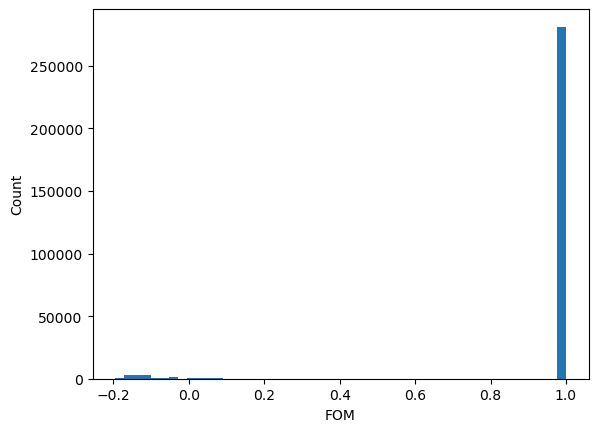

In [12]:
# Plot the histogram of fom_array
plt.hist(fom_array, bins=50)
plt.xlabel('FOM')
plt.ylabel('Count')
plt.show()

Look at the bad fits

In [13]:
params_labal_list = ['nh', 'T', 'chi', 'xh', 'xC', 'y', 'dipole', 'a', 'beta', 'ip']

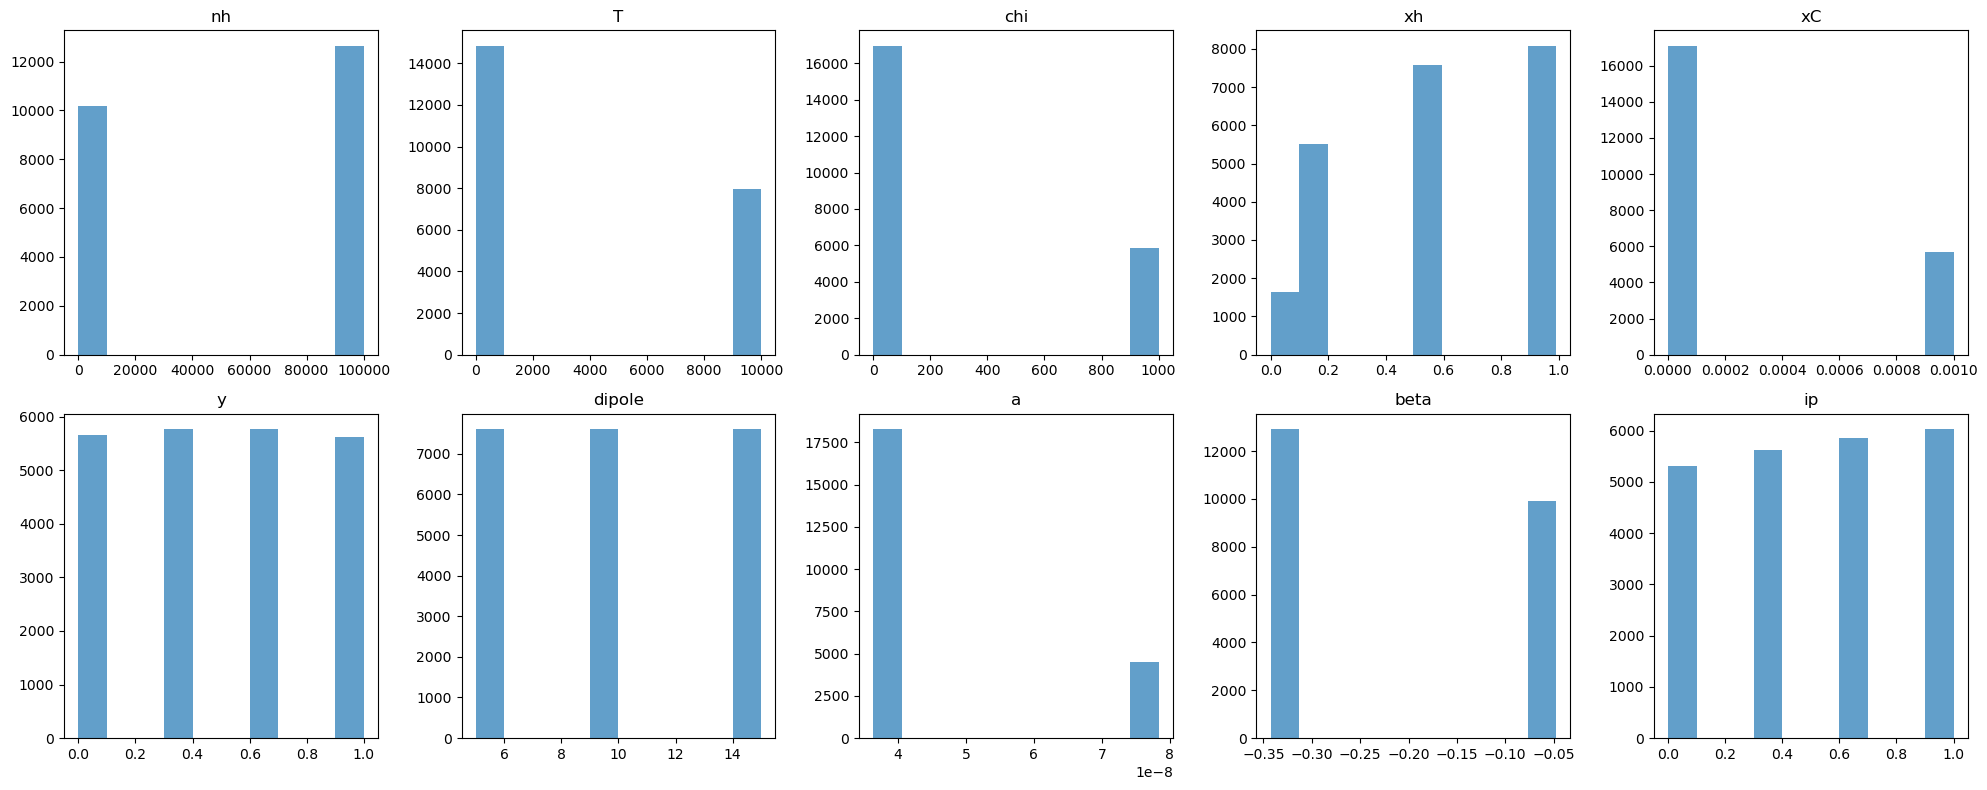

In [14]:
# Invalid indices

bad_inds = np.where(fom_array<0.99)[0] 

arr = P[bad_inds,:]

# Suppose arr is your (N, 10) array
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.hist(arr[:, i], bins=10, alpha=0.7)
    ax.set_title(params_labal_list[i])
plt.tight_layout()
plt.show()

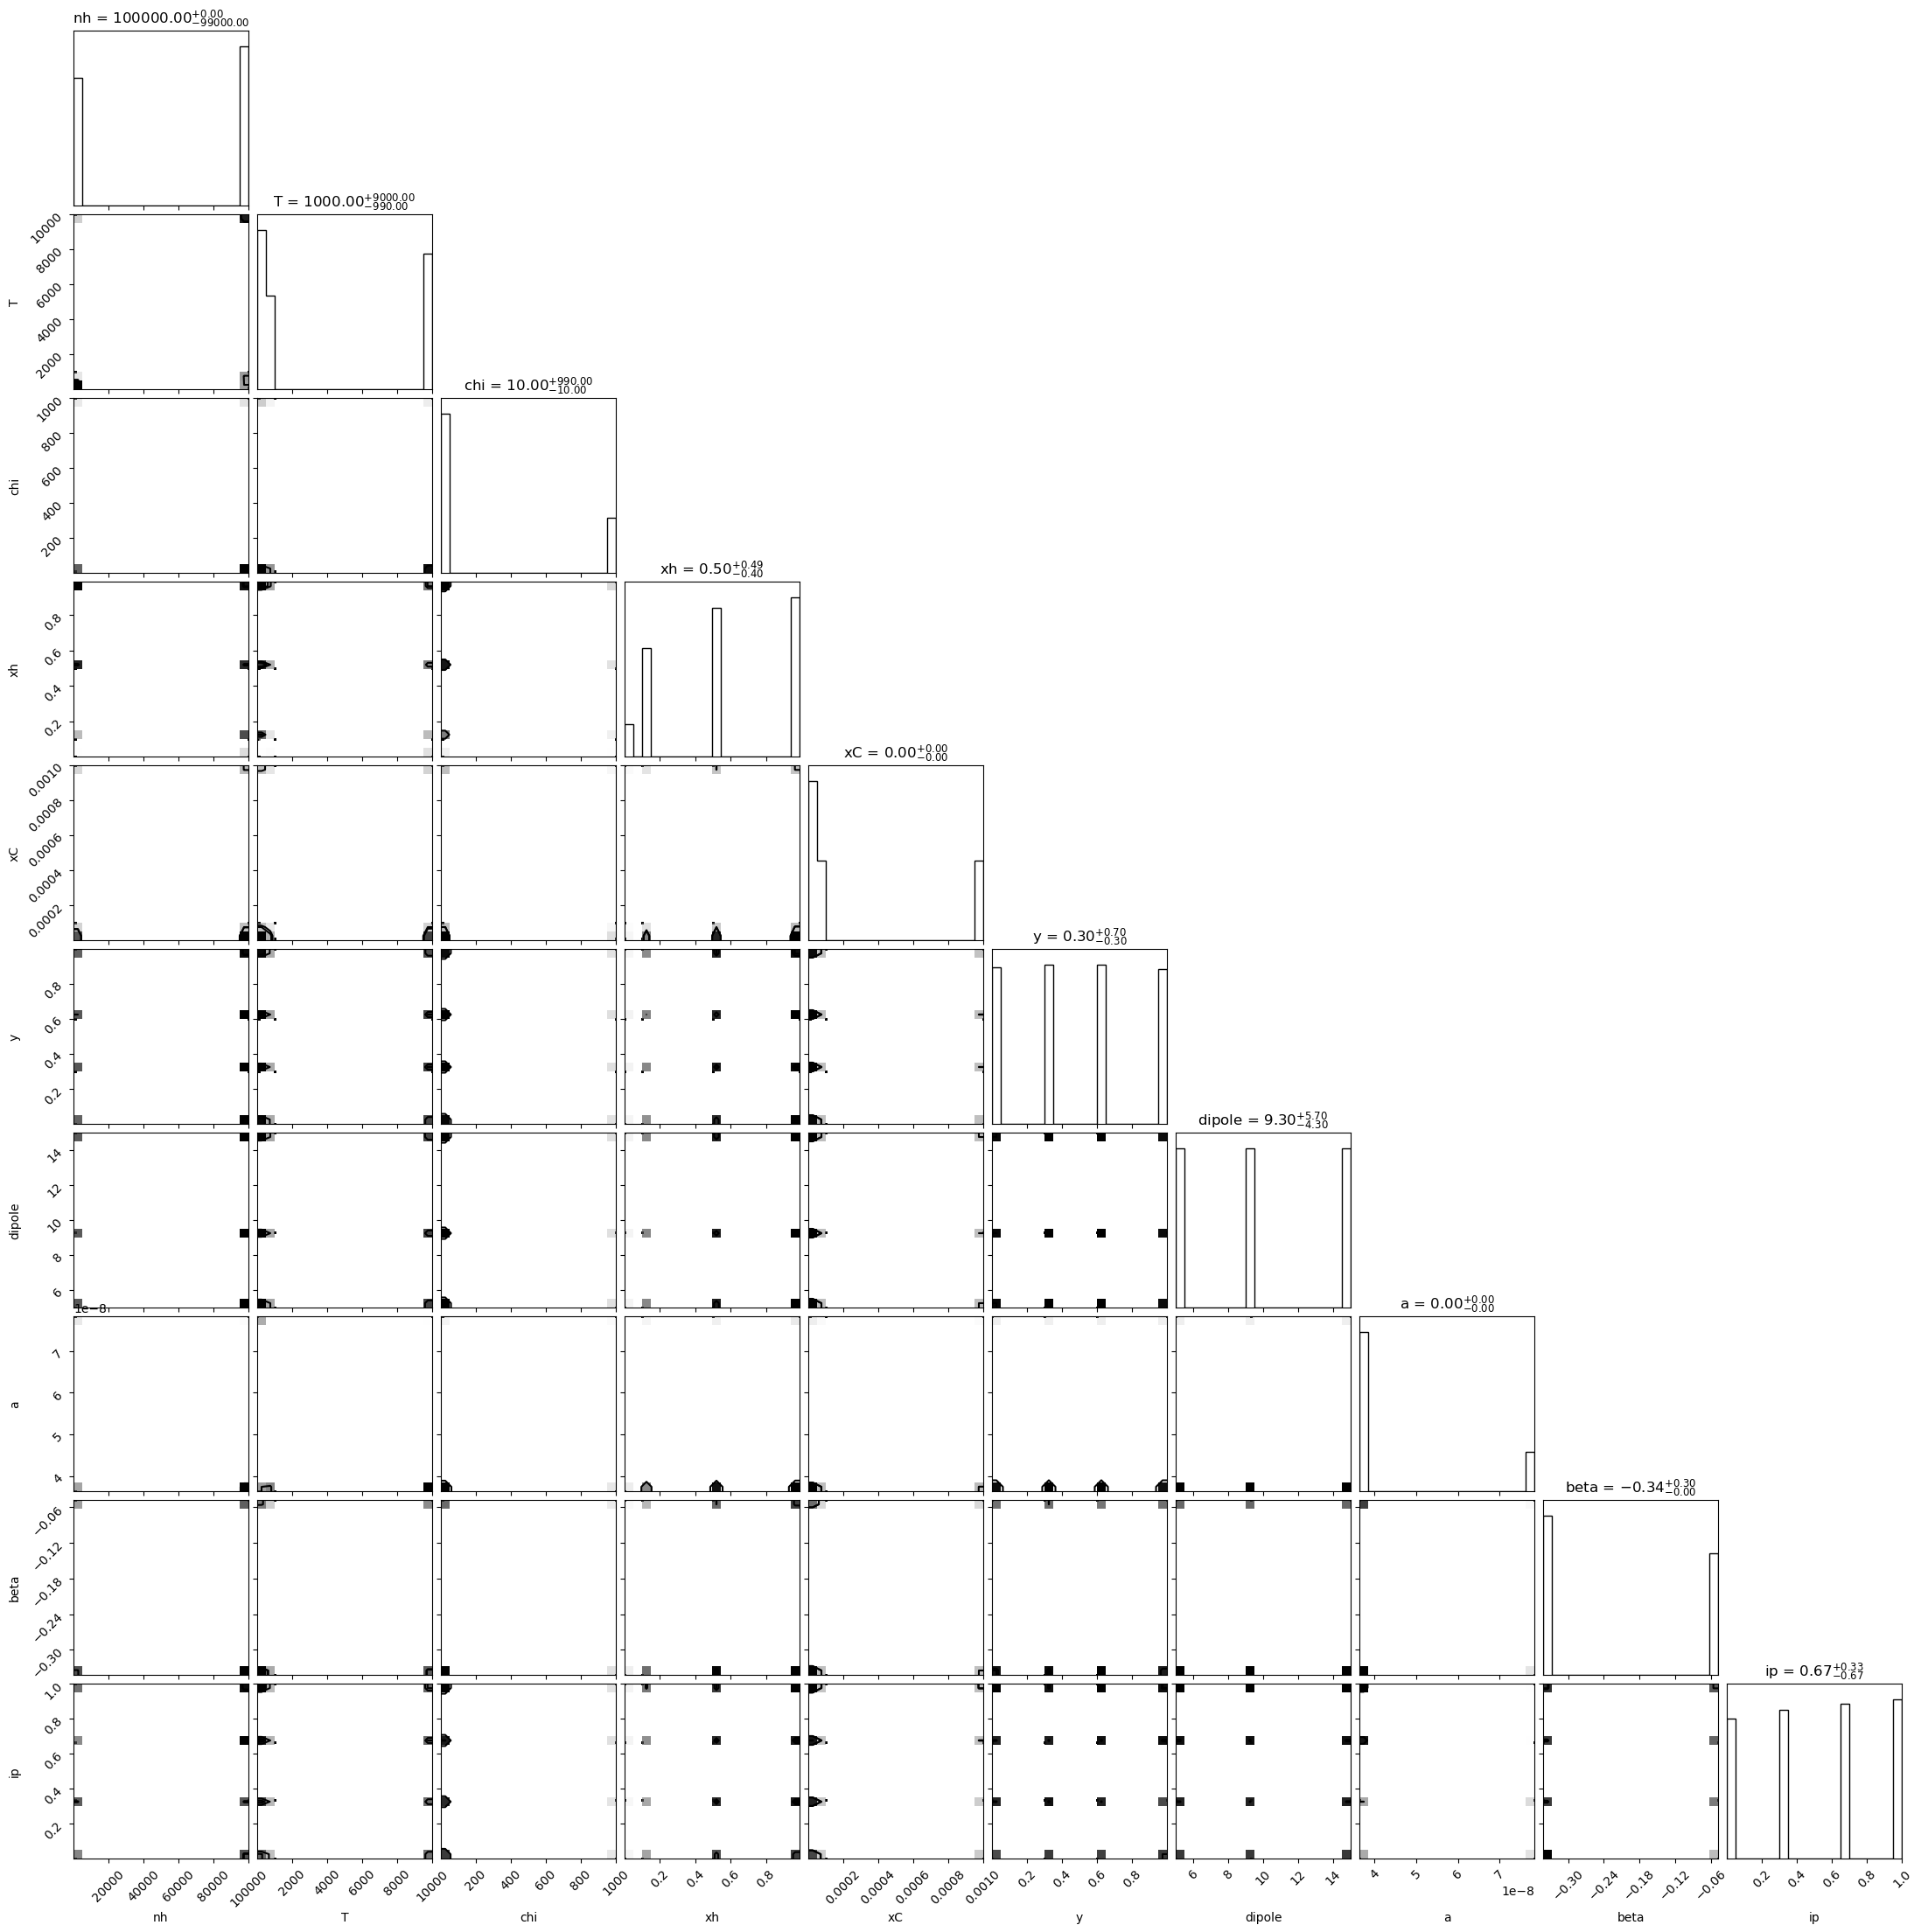

In [15]:
import corner
# arr should be your (N, 10) array of parameters
figure = corner.corner(arr, labels=params_labal_list, show_titles=True)

In [16]:
inds = np.where(fom_array>0.99)[0]

fom_array = fom_array[inds]
summary_params = summary_params[inds]
raw_params = P[inds]

len(np.where(fom_array>0.99)[0])

272094

## Symbolic Regression

In [20]:
beta

np.float64(-0.3425)

In [25]:
DC_params = [ 1e4, 10., 1e-4, 0., 1e-6, 0.999,  9.3, a, beta, 2/3]

MC_params = [ 3e2, 20., 1e-2, 0., 1e-4, 0.99, 9.3,  a, beta, 2/3] 

CNM_params = [ 30, 100., 1, 1.2e-3,  3e-4, 0, 9.3,  a, beta, 2/3]

WNM_params = [0.4, 6000., 1., 0.1, 3e-4, 0, 9.3,  a, beta, 2/3]

WIM_params = [0.1, 8000., 1., 0.99, 1e-3, 0, 9.3,  a, beta, 2/3]

RN_params = [1000., 100., 1000., 0.001, 2e-4, 0.5, 9.3,  a, beta, 2/3]

PDR_params = [1e5, 300., 3000., 0.0001, 2e-4, 0.5, 9.3,  a, beta, 2/3]

test_params_list = [DC_params, MC_params, CNM_params, WNM_params, WIM_params, RN_params, PDR_params]

In [ ]:
from pysr import PySRRegressor

model_a = PySRRegressor(
    niterations=100,
    #model_selection="best",
    binary_operators=["+", "-", "*", "/", "pow"],
    unary_operators=["log", "exp", "sqrt"],
    batching=True,
    #verbosity=1,
)

# Perform symbolic regression on "a"
model_a.fit(raw_params, summary_params[:, 0])  
# print(model_a)


In [26]:
model_b = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/", "pow"],
    unary_operators=["log", "exp", "sqrt"],
    batching=True,
)

# Perform symbolic regression on "b"
model_b.fit(raw_params, summary_params[:, 1])  

/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust-dev/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust-dev/lib/python3.13/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.580e+03
Progress: 295 / 3100 total iterations (9.516%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.348e+13  0.000e+00  y = -1.3929e+06
5           2.343e+13  -0.000e+00  y = 5.9781e+05 - (x₀ + 1.8641e+06)
8           2.286e+13  -0.000e+00  y = (x₆ / (x₁ / exp(x₆))) / -0.96934
10          2.285e+13  -0.000e+00  y = x₆ / (x₁ / (exp(x₆) / (-0.83417 + x₈)))
17          2.277e+13  -0.000e+00  y = (((x₀ * x₆) / x₁) ^ 1.1749) * (((x₀ / (x₈ / x₁)) * x₇...
                                       ) + -1.192)
21          2.261e+13  -0.000e+00  y = ((-2.8789 * x₀) / (x₁ / ((log(x₇) * (247 * -2.8789)) ...
                                       / (x₁ ^ 1.6789)))) - (exp(x₃) * 36.62)
28          1.994e+13  -0.000e+00  y = ((x₁ - x₀) - ((x₉ * 0.37856) * x₄

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -1.232856e6   
	1         0.055168                                  x7 * -9.359041e12   
	2         0.060310                        -154282.3 / (x1 - 9.968417)   
	3         0.000575                 (-154282.3 / (x1 - 9.968417)) - x0   
	4         0.360295         (exp(exp(34.2786 / x1)) * x7) * -1.6092558   
	5         0.055408   x7 * ((-1.347879 - x3) * exp(exp(34.2786 / x1)))   
	6         0.027012  (-0.822153 - sqrt(x3)) * (x7 * exp(exp(34.2786...   
	7   >>>>  0.092766  (-0.82215303 - sqrt(sqrt(x3))) * (x7 * exp(exp...   
	8         0.049886  (-0.822153 - sqrt(sqrt(sqrt(x3)))) * (x7 * exp...   
	9         0.032115  exp(exp((28.939646 / x1) + 0.549109)) * ((-0.3...   
	10        0.045953  ((x7 * (-0.28882852 - sqrt(sqrt(sqrt(x3))))) *...   
	11        0.000771  (x7 * exp(exp((sqrt(sqrt(x3)) / (x2 - -28.1626...   
	12        0.038112  x7 * (exp(exp((sqrt(sqrt(sqrt(x3))) / (x2 - -2...   
	13        0.038423  exp(exp((sqrt(sqrt(sqrt(x3))) / (sqrt(x2) - -2...   
	14        0.030831  exp(exp((sqrt(sqrt(sqrt(sqrt(x3)))) / (sqrt(x2...   
	15        0.009879  (-10.527369 * exp(exp((sqrt(sqrt(sqrt(sqrt(sqr...   
	16        0.000015  ((-10.527369 * exp(exp((sqrt(sqrt(sqrt(sqrt(sq...   
	17        0.000290  ((-10.527369 * (exp(exp((sqrt(sqrt(sqrt(sqrt(s...   
	
	            loss  complexity  
	0   2.345227e+13           1  
	1   2.100229e+13           3  
	2   1.861582e+13           5  
	3   1.859442e+13           7  
	4   9.045531e+12           9  
	5   8.096686e+12          11  
	6   7.880910e+12          12  
	7   7.182713e+12          13  
	8   6.833190e+12          14  
	9   6.617230e+12          15  
	10  6.320027e+12          16  
	11  6.305432e+12          19  
	12  6.069643e+12          20  
	13  5.840854e+12          21  
	14  5.663521e+12          22  
	15  5.607845e+12          23  
	16  5.607678e+12          25  
	17  5.599548e+12          30  
]

  - outputs/20250617_081024_n2ESjR/hall_of_fame.csv


In [27]:
model_c = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/", "pow"],
    unary_operators=["log", "exp", "sqrt"],
    batching=True,
)

# Perform symbolic regression on "c"
model_c.fit(raw_params, summary_params[:, 2])  

/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust-dev/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust-dev/lib/python3.13/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.280e+03
Progress: 262 / 3100 total iterations (8.452%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.470e+07  0.000e+00  y = 3565.5
3           9.457e+07  -0.000e+00  y = 3825.5 - x₂
8           9.439e+07  -0.000e+00  y = ((16.114 - sqrt(x₁)) - x₂) + 3809.6
9           7.718e+07  -0.000e+00  y = (((0.98588 ^ x₁) / 0.33719) ^ x₁) - -1653.7
13          6.455e+07  -0.000e+00  y = (14.679 + (((x₇ * 38633) / 0.016643) - 14.793)) * (18...
                                       355 - x₁)
17          6.455e+07  -0.000e+00  y = ((14.679 + (x₇ * (38633 / 0.016643))) - (14.793 - (-0...
                                       .88018 / 33954))) * (18355 - x₁)
19          6.455e+07  -0.000e+00  y = (((x₇ * 2.3213e+06) - (14.793 - ((-0.88018 - (x₄ * 38...
 

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                           3565.549   
	1         1.216987e-01                                  x7 * 2.7626134e10   
	2         5.099690e-01                            8.545654e11 * (x7 / x1)   
	3         8.567816e-03             x7 * (1.6596305e12 / (x1 - -8.938462))   
	4         2.707120e-02                x7 * (7.193673e11 / (x1 - exp(x3)))   
	5         3.887815e-02  ((-6757.5156 * x7) / (x1 / -179589.5)) ^ 2.775...   
	6         1.997726e-02           (x7 * 6.564837e11) / (x1 - exp(x3 ^ x7))   
	7         8.280999e-08     x7 * (6.564837e11 / (x1 - exp(sqrt(x3) ^ x7)))   
	8         7.354427e-02  x7 * ((4.0630383e12 / x1) / (sqrt(3.2539704e12...   
	9         1.808234e-02  (x7 * (3.2539704e12 / x1)) / ((-1042.494 + sqr...   
	10        2.527379e-02  (-20023.39 / (0.0049602147 / (-646076.94 / x1)...   
	11        9.997439e-02  x7 * ((3.2539704e12 / x1) / ((-1042.494 + sqrt...   
	12  >>>>  1.970732e-01  ((x7 * ((-3.0402508e6 / (x1 / -36980.65)) / ((...   
	13        9.785377e-03  (x2 + (((-1.8034831e6 / (x1 / -79589.35)) * (x...   
	14        3.245820e-02  (((x7 / (7.9601893 - (sqrt(x3) - ((x2 / x0) / ...   
	15        1.058684e-05  ((((x7 / (7.9601893 - (sqrt(x3) - ((x2 / x0) /...   
	
	          loss  complexity  
	0   94703540.0           1  
	1   74243784.0           3  
	2   26773592.0           5  
	3   26318718.0           7  
	4   25615796.0           8  
	5   24639012.0           9  
	6   24151676.0          10  
	7   24151674.0          11  
	8   22439200.0          12  
	9   21642192.0          14  
	10  21102066.0          15  
	11  19094428.0          16  
	12  15679018.0          17  
	13  14784970.0          23  
	14  13413163.0          26  
	15  13412595.0          30  
]

  - outputs/20250617_081144_WO8jDr/hall_of_fame.csv


In [30]:
def SR_pred_dist(freqs_100GHz, env_list):
    a_list = model_a.predict(env_list)
    b_list = model_b.predict(env_list)
    c_list = model_c.predict(env_list)
    rot_list = []
    for i in range(len(env_list)):
        a = a_list[i]
        b = b_list[i]
        c = c_list[i]
        rot_list.append(model_func(freqs_100GHz, a, b, c))
    return rot_list

def true_dist(env_list):
    rot_list = []
    for env in env_list:
        _, log_rot = cond_rot_dist_sorted(env)
        rot_list.append(np.exp(log_rot[0]))
    return rot_list

In [31]:
SR_rot_results = SR_pred_dist(freqs_100GHz, test_params_list)
true_rot_list = true_dist(test_params_list)

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_22926/64291771.py:3: RuntimeWarning: overflow encountered in exp
  return a * x**2 * np.exp(-b * x**4 - c * x**2)


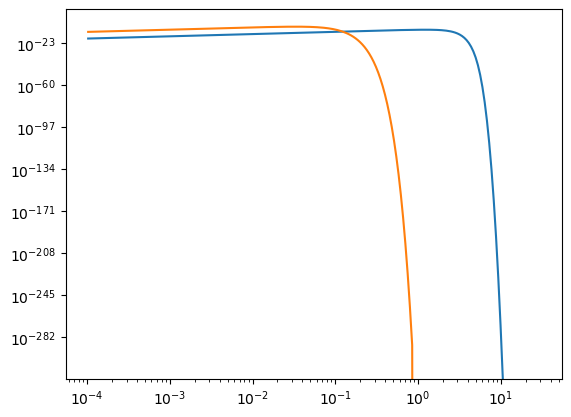

In [36]:
plt.loglog(freqs_100GHz, true_rot_list[1])
plt.loglog(freqs_100GHz, SR_rot_results[1])

In [ ]:
# Make plots to compare SR_rot_results and true_rot_list (7 subplots)

fig, axs = plt.subplots(7, 1, figsize=(10, 10))
axs[0].loglog(freqs_100GHz, true_rot_list[0], label='True')
axs[0].loglog(freqs_100GHz, SR_rot_results[0], label='SR')

axs[1].plot(freqs_100GHz, true_rot_list[1], label='True')
axs[1].plot(freqs_100GHz, SR_rot_results[1], label='SR')

axs[2].plot(freqs_100GHz, true_rot_list[2], label='True')
axs[2].plot(freqs_100GHz, SR_rot_results[2], label='SR')
axs[3].plot(freqs_100GHz, true_rot_list[3], label='True')
axs[3].plot(freqs_100GHz, SR_rot_results[3], label='SR')
axs[4].plot(freqs_100GHz, true_rot_list[4], label='True')
axs[4].plot(freqs_100GHz, SR_rot_results[4], label='SR')
axs[5].plot(freqs_100GHz, true_rot_list[5], label='True')
axs[5].plot(freqs_100GHz, SR_rot_results[5], label='SR')
axs[6].plot(freqs_100GHz, true_rot_list[6], label='True')
axs[6].plot(freqs_100GHz, SR_rot_results[6], label='SR')
# Add labels and legends
axs[0].set_ylabel('Rotation Distribution')
axs[6].set_xlabel('Frequency (Hz)')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()
axs[6].legend()
# Show the plot
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust-dev/lib/python3.13/site-packages/matplotlib/ticker.py:2468: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


OverflowError: cannot convert float infinity to integer

<Figure size 1000x1000 with 7 Axes>

In [ ]:
from sympy import symbols, lambdify

In [ ]:
model_a.predict(test_params_list)

### Appendix: fitting example

In [ ]:
plt.plot(freqs_GHz, f_rot)
plt.plot(freqs_GHz, model_func(freqs_GHz, *popt) , '--', label='Fit')
plt.xscale('log')

In [ ]:
inds = np.where(log_rot_dist[0]>-60)
popt, pcov = curve_fit(quasi_polynomial, log_omegas[inds], np.exp(log_rot_dist[0][inds]), method = 'trf')
goodness_of_fit(log_omegas, np.exp(log_rot_dist[0]), popt)

In [ ]:
plt.plot(log_omegas,  log_rot_dist[0] )

In [ ]:
class spdust_conditional_SED:
    def __init__(self, obs_omegas, int_dist_func=homogeneous_dist, ext_dist_func=homogeneous_dist, impulse=None):
        self.obs_omegas = obs_omegas
        self.int_dist_func = int_dist_func
        self.ext_dist_func = ext_dist_func
        self.impulse = impulse

    @staticmethod
    def generate_loglog_rot_dist_func(env, a, beta, mu, ip):
        fZ = charge_dist(env, a, beta)
        mu_ip = np.array([mu * np.sqrt(ip)])
        mu_op = np.array([mu * np.sqrt(1 - ip)])
        log_Omegas, log_rot_dist = log_f_rot(env, a, beta, fZ, mu_ip, mu_op, omega_min=1e7, omega_max=3e13, Nomega=1000)
        return log_Omegas, log_rot_dist[0]

    def generate(self, env, a, beta, mu, ip):
        self.log_omegas, self.log_rot_dist = self.generate_loglog_rot_dist_func(env, a, beta, mu, ip)
        spdust_model = full_Stokes_SED(rot_freq_grid=self.log_omegas, rot_dist_grid=self.log_rot_dist,
                                       log_freq=True, log_dist=True)
        result = spdust_model.generate_SED(self.obs_omegas, beta, ip, mu**2,
                                            internal_dist=self.int_dist_func, 
                                            impulse=self.impulse,
                                            external_dist=self.ext_dist_func, 
                                            max_workers=1, 
                                            full_Stokes=True)

        return result

In [ ]:
def normalized_distribution(cos_theta_L, phi_L, sigma=0.1):
    """
    Normalized 2D Gaussian distribution peaked at (cos_theta_L, phi_L)
    
    Args:
        cos_theta_L: Peak position in cos(theta) (range: [-1, 1])
        phi_L: Peak position in azimuthal angle (range: [0, 2π])
        sigma: Standard deviation controlling distribution width
    
    Returns:
        Probability function f(x, y) normalized over [-1,1] × [0,2π]
    """
    import numpy as np
    
    # Normalization constant (precomputed integral over valid domain)
    norm = 1 / (2 * np.pi * sigma**2)
    
    def f(x, y):
        # Radial component (cos_theta) with boundary constraints
        radial = np.exp(-(x - cos_theta_L)**2 / (2 * sigma**2))
        
        # Angular component with periodic boundary conditions
        angular = np.exp(-(np.minimum(np.abs(y - phi_L), 
                                    2*np.pi - np.abs(y - phi_L))**2) 
                        / (2 * sigma**2))
        return radial * angular * norm
    
    return f

example_anisotropic_distribution = normalized_distribution(0.3, np.pi/2)

In [ ]:
obs_omegas_min = 2*np.pi*3e9
obs_omegas_max = 2*np.pi*3e11
obs_omegas_num = 1000
obs_omegas = makelogtab(obs_omegas_min , obs_omegas_max , obs_omegas_num)

spd_model = spdust_conditional_SED(obs_omegas, ext_dist_func=example_anisotropic_distribution)

In [ ]:
debye = cgsconst.debye
env = CNM_params
dip_per_at = env['dipole'] / np.sqrt(N_C(1e-7) + N_H(1e-7)) * debye

aind = 5
a = a_tab[aind]
beta = beta_tab[np.argmax(f_a_beta[aind, :])]
fZ = charge_dist(env, a, beta)
Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
mu_rms = rms_dipole(a, beta, Z2, dip_per_at)

In [ ]:
spd_SED = spd_model.generate(CNM_params, a, beta, mu_rms, 2/3)

In [ ]:
spd_SED.shape

In [ ]:
plt.plot(spd_model.log_omegas, np.exp(spd_model.log_rot_dist))
#plt.ylim(-100, 10)

In [ ]:
import matplotlib.ticker as mticker  # Add this at the top of your imports


plt.figure(figsize=(10, 6))

# Plot with increased line widths and distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.plot(obs_omegas, spd_SED[0,:], label='Stokes I', lw=2, color=colors[0])
plt.plot(obs_omegas, spd_SED[1,:], label='Stokes Q', ls='--', lw=1.5, color=colors[1])
plt.plot(obs_omegas, spd_SED[2,:], label='Stokes U', ls=':', lw=1.5, color=colors[2])
plt.plot(obs_omegas, spd_SED[3,:], label='Stokes V', ls='-.', lw=1.5, color=colors[3])

# Formatting
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(1e-20, 1e-1)

# Axis labels with LaTeX formatting
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.title('Stokes Parameters Spectrum', fontsize=14)

# Legend and grid
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.8, 1), fontsize=12)
plt.grid(True, which='both', ls=':', alpha=0.5)

# Scientific notation formatting
plt.tick_params(axis='both', which='both', labelsize=10)
# plt.gca().xaxis.set_minor_formatter(mticker.ScalarFormatter())
# plt.gca().yaxis.set_major_formatter(mticker.LogFormatterSciNotation()) 
plt.tight_layout()
plt.savefig('stokes_spectrum.pdf')
